In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go

In [2]:
import os
import sys

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
from core.time_series_clustering import KmeansClustering
from core.data_preparation import DataPreparation


/home/ambekar/anaconda3/envs/rpy/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
from core.curve_fit import fit_polynomial_curve_to_data_and_visualize

Load and Prepare data to input to LSTM model

In [5]:
filepath = "../Data/BHARTIARTL_2010-01-012022-02-10.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2010-01-04,329.85,332.10,323.85,325.20,2952340,BHARTIARTL
1,2010-01-05,328.25,332.00,325.50,330.35,4302024,BHARTIARTL
2,2010-01-06,332.95,335.15,326.10,326.85,4409919,BHARTIARTL
3,2010-01-07,328.35,334.00,328.00,329.40,3868937,BHARTIARTL
4,2010-01-08,329.75,331.45,324.65,325.05,2655707,BHARTIARTL


In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='closing price'))

In [8]:
window_size = 20
prep = DataPreparation()
scaler = MinMaxScaler(feature_range=(-1, 1))

In [9]:
scaler, x_train, x_test, y_train_lstm, y_test_lstm = prep.normalize_and_prepare_data(data['Close'].values, scaler)

x_train.shape =  (2386, 20, 1)
y_train.shape =  (2386, 1)
x_test.shape =  (582, 20, 1)
y_test.shape =  (582, 1)


In [10]:
num_clusters = 6

In [11]:
kmeans = KmeansClustering(num_clusters)
kmeans.compute_clusters(x_train)

DBA k-means


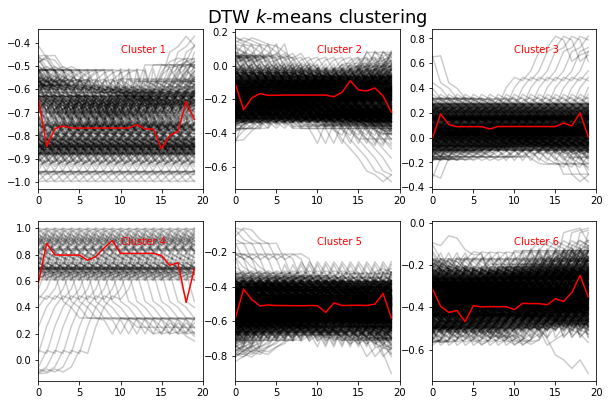

In [12]:
kmeans.visualize_clustering_results()

In [13]:
y_train = y_train_lstm.flatten().numpy()

In [14]:
type(y_train)

numpy.ndarray

In [15]:
train_errors = pd.read_csv('Airtel_ErrorDistribution.csv', usecols=[2])
train_errors.head()

,diff
0,3.193451
1,0.604736
2,3.727844
3,6.286408
4,3.271545


In [16]:
clusters = []
for i in range(num_clusters):

    clusters.append(scaler.inverse_transform(kmeans.cluster_centers_[i].flatten().reshape(-1,1)))

In [17]:
# y2 = scaler.inverse_transform(kmeans.cluster_centers_[2].flatten().reshape(-1,1))
# y2

In [18]:
# clusters[2]

In [19]:
kmeans.cluster_centers_[2].flatten()

array([-0.00875995,  0.19060255,  0.1058901 ,  0.08787862,  0.08835374,
        0.08836567,  0.08814071,  0.0691228 ,  0.08952459,  0.08940188,
        0.08940188,  0.08973933,  0.08939165,  0.08939165,  0.08916498,
        0.08917095,  0.11758379,  0.09431675,  0.19968394,  0.00639904])

In [20]:
train_preds = kmeans.predict(x_train)

In [21]:
for i in range(num_clusters):
    print(f"cluster {i}- {len(kmeans.data[kmeans.data_preds == i])}")

cluster 0- 232
cluster 1- 508
cluster 2- 390
cluster 3- 76
cluster 4- 640
cluster 5- 540


In [22]:
model = torch.load('lstm_airtel.pt')
model.eval()

/home/ambekar/anaconda3/envs/rpy/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning:

source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.

/home/ambekar/anaconda3/envs/rpy/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning:

source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.



LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [23]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

Test Score: 0.04 MAPE
R-squared value is 0.7983097982310164
RMSE:  41.8582187107002


#### Predict the cluster for forecast data

In [24]:
#prepare forecasts for clustering

preds = y_test_pred.detach().numpy()
preds = preds[:,0]
loop = len(preds) - window_size + 1 
forecasts = []

for i in range(loop):        
    window = preds[i:i+window_size]
    forecasts.append(window)  

forecasts = np.asarray(forecasts).reshape(-1, window_size, 1)

In [25]:
#prepare test gt for performance comparison

gt = y_test_lstm.detach().numpy()
gt = gt[:,0]
loop = len(gt) - window_size + 1 
test_gt = []

for i in range(loop):        
    window = gt[i:i+window_size]
    test_gt.append(window)  

test_gt = np.asarray(test_gt).reshape(-1, window_size, 1)

In [26]:
test_gt.shape, forecasts.shape

((563, 20, 1), (563, 20, 1))

In [27]:
# forecasts

In [28]:
res = kmeans.predict(forecasts)

In [29]:
# np.where(res == 6)

#### Find distances between each cluster centroid and a reference time series

In [30]:
ref_ts = np.zeros(20)

In [31]:
ref_ts

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [32]:
clusters[0].flatten()

array([296.08906696, 265.19142386, 276.85061765, 278.56814487,
       277.25603408, 277.25603408, 277.25603408, 277.25603408,
       277.25603408, 277.25603408, 277.25603408, 277.25603408,
       279.47391357, 276.60452521, 276.58168077, 263.73897818,
       272.44667882, 274.98532425, 294.46111705, 282.77430579])

In [33]:
clusters_wd_dist = []
for i in range(num_clusters):

    wd = kmeans.compute_wasserstein_distance(ref_ts, clusters[i].flatten())

    clusters_wd_dist.append(wd)


In [34]:
clusters_wd_dist

[277.7093049866383,
 366.60003180670475,
 406.5438824553423,
 508.23269220891564,
 316.1959242786065,
 335.16265256021563]

In [35]:
f380 = scaler.inverse_transform(forecasts[380].flatten().reshape(-1,1))

In [36]:
kmeans._get_statistical_dist_measures(f380.flatten(), np.zeros(20))

{'Anderson_Darling_dist': 3.708417172625208,
 'CVM_dist': 10.450000000000003,
 'DTS_dist': 172.1941074339606,
 'Kolmogorov_Smirnov_dist': 1.0000000000000002,
 'Kuiper_dist': 1.0000000000000002,
 'Wasserstein distance': 542.0896942138673}

In [37]:
len(forecasts)

563

In [38]:
# np.random.seed(4)

## Fix these values of indices to reacreate/edit plots

indices = [381, 349, 366, 515, 536, 280,  10, 336, 319,  81,  34, 396, 231,
       420, 246]


# indices = np.random.choice(range(0, len(forecasts), 1), 15)
# indices

In [39]:
# t = [130, 184, 244, 225, 160, 235, 245, 176, 175, 30, 264, 256, 278, 300, 305, 380, 406, 420, 450, 467]

t = indices
df = kmeans.ecdf_between_cluster_and_data(t, scaler, forecasts, res, clusters_wd_dist)

In [40]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance
0,381,0.993953,3,508.232692,5.975128,16.50,13.592309,0.90,0.90,33.887371
1,349,0.895716,3,508.232692,4.972141,13.60,8.858038,0.85,0.85,18.922778
2,366,0.894151,3,508.232692,5.390888,14.70,8.304184,0.85,0.85,18.815002
3,515,1.519748,3,508.232692,6.101857,16.90,37.963455,1.00,1.00,113.006051
4,536,1.485833,3,508.232692,6.101857,16.90,36.455883,1.00,1.00,107.862747
5,280,0.635255,3,508.232692,4.517755,12.70,7.843374,0.70,0.75,20.599891
6,10,-0.060448,2,406.543882,4.659667,12.85,9.955157,0.80,0.95,28.136646
7,336,1.110313,3,508.232692,6.006910,16.60,19.150075,0.90,0.90,51.369043
8,319,1.197654,3,508.232692,6.101857,16.90,22.758963,1.00,1.00,64.525302
9,81,0.932478,3,508.232692,5.239970,14.30,10.312166,0.80,0.80,24.592239


In [41]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance
0,381,0.993953,3,508.232692,5.975128,16.50,13.592309,0.90,0.90,33.887371
1,349,0.895716,3,508.232692,4.972141,13.60,8.858038,0.85,0.85,18.922778
2,366,0.894151,3,508.232692,5.390888,14.70,8.304184,0.85,0.85,18.815002
3,515,1.519748,3,508.232692,6.101857,16.90,37.963455,1.00,1.00,113.006051
4,536,1.485833,3,508.232692,6.101857,16.90,36.455883,1.00,1.00,107.862747
5,280,0.635255,3,508.232692,4.517755,12.70,7.843374,0.70,0.75,20.599891
6,10,-0.060448,2,406.543882,4.659667,12.85,9.955157,0.80,0.95,28.136646
7,336,1.110313,3,508.232692,6.006910,16.60,19.150075,0.90,0.90,51.369043
8,319,1.197654,3,508.232692,6.101857,16.90,22.758963,1.00,1.00,64.525302
9,81,0.932478,3,508.232692,5.239970,14.30,10.312166,0.80,0.80,24.592239


In [42]:
df['WD ratio'] = df['Wasserstein distance'] / df['WD origin']

In [43]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio
0,381,0.993953,3,508.232692,5.975128,16.50,13.592309,0.90,0.90,33.887371,0.066677
1,349,0.895716,3,508.232692,4.972141,13.60,8.858038,0.85,0.85,18.922778,0.037233
2,366,0.894151,3,508.232692,5.390888,14.70,8.304184,0.85,0.85,18.815002,0.037020
3,515,1.519748,3,508.232692,6.101857,16.90,37.963455,1.00,1.00,113.006051,0.222351
4,536,1.485833,3,508.232692,6.101857,16.90,36.455883,1.00,1.00,107.862747,0.212231
5,280,0.635255,3,508.232692,4.517755,12.70,7.843374,0.70,0.75,20.599891,0.040532
6,10,-0.060448,2,406.543882,4.659667,12.85,9.955157,0.80,0.95,28.136646,0.069209
7,336,1.110313,3,508.232692,6.006910,16.60,19.150075,0.90,0.90,51.369043,0.101074
8,319,1.197654,3,508.232692,6.101857,16.90,22.758963,1.00,1.00,64.525302,0.126960
9,81,0.932478,3,508.232692,5.239970,14.30,10.312166,0.80,0.80,24.592239,0.048388


In [44]:
rmse_errors = []
mape_errors = []
r2score = []
for i in t:

    forecast = scaler.inverse_transform(forecasts[i])
    gt = scaler.inverse_transform(test_gt[i])
    rmse = math.sqrt(mean_squared_error(gt, forecast))
    rmse_errors.append(rmse)

    mape = mean_absolute_percentage_error(gt, forecast)
    mape_errors.append(mape*100)

    r2 = r2_score(gt, forecast)
    r2score.append(r2)

In [45]:
df = df.assign(**{'RMSE': rmse_errors, 'MAPE':mape_errors, 'R2-score': r2score})

In [46]:
df 

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio,RMSE,MAPE,R2-score
0,381,0.993953,3,508.232692,5.975128,16.50,13.592309,0.90,0.90,33.887371,0.066677,14.360479,0.022573,0.199910
1,349,0.895716,3,508.232692,4.972141,13.60,8.858038,0.85,0.85,18.922778,0.037233,6.646066,0.009550,0.264143
2,366,0.894151,3,508.232692,5.390888,14.70,8.304184,0.85,0.85,18.815002,0.037020,9.938393,0.015192,-0.343449
3,515,1.519748,3,508.232692,6.101857,16.90,37.963455,1.00,1.00,113.006051,0.222351,111.613202,0.150554,-44.101618
4,536,1.485833,3,508.232692,6.101857,16.90,36.455883,1.00,1.00,107.862747,0.212231,70.955766,0.101178,-20.351810
5,280,0.635255,3,508.232692,4.517755,12.70,7.843374,0.70,0.75,20.599891,0.040532,11.111041,0.017120,0.563478
6,10,-0.060448,2,406.543882,4.659667,12.85,9.955157,0.80,0.95,28.136646,0.069209,17.260284,0.030433,0.630824
7,336,1.110313,3,508.232692,6.006910,16.60,19.150075,0.90,0.90,51.369043,0.101074,12.006793,0.017853,0.788402
8,319,1.197654,3,508.232692,6.101857,16.90,22.758963,1.00,1.00,64.525302,0.126960,19.619279,0.027092,-1.329113
9,81,0.932478,3,508.232692,5.239970,14.30,10.312166,0.80,0.80,24.592239,0.048388,14.819690,0.019791,-0.363532


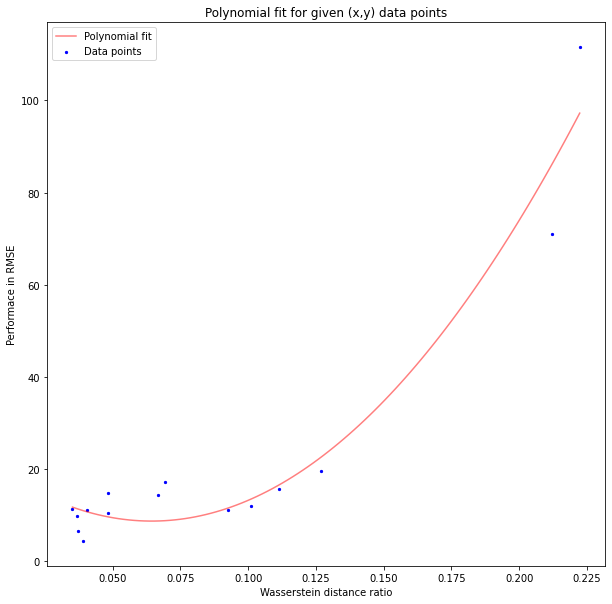

In [47]:
fit_polynomial_curve_to_data_and_visualize(df['WD ratio'].values, rmse_errors, 2, xlabel='Wasserstein distance ratio', ylabel='Performace in RMSE')

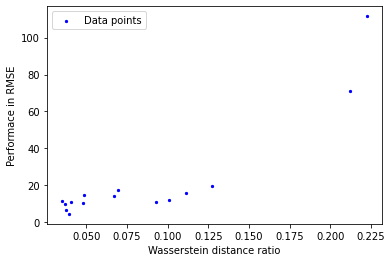

In [48]:
#Plotting
fig1 = plt.figure()
ax1 = fig1.subplots()
ax1.scatter(df['WD ratio'], rmse_errors, s = 5, color = 'b', label = 'Data points')
ax1.set_xlabel('Wasserstein distance ratio')
ax1.set_ylabel('Performace in RMSE')
ax1.legend()
plt.show()

#### Find MSE of each data point using CONFINE method

In [49]:
for i in range(num_clusters):
    print(f"cluster {i}- {len(kmeans.data[kmeans.data_preds == i])}")

cluster 0- 232
cluster 1- 508
cluster 2- 390
cluster 3- 76
cluster 4- 640
cluster 5- 540


In [50]:
num_neighbors = 76

In [51]:
y_train = y_train_lstm.flatten().numpy()

##### Get indices of the training points that have been assigned to respective cluster

In [52]:
cluster0 = (np.where(kmeans.labels_ == 0))
cluster1 = (np.where(kmeans.labels_ == 1))
cluster2 = (np.where(kmeans.labels_ == 2))
cluster3 = (np.where(kmeans.labels_ == 3))
cluster4 = (np.where(kmeans.labels_ == 4))
cluster5 = (np.where(kmeans.labels_ == 5))

##### Get the difference between train preds and train gt values 

In [53]:
train_diff_df = pd.read_csv('Airtel_ErrorDistribution.csv', usecols=[2])
train_diff_df.head()

,diff
0,3.193451
1,0.604736
2,3.727844
3,6.286408
4,3.271545


##### Get training points (members) of each cluster 

In [54]:
training_diff = train_diff_df['diff']
training_diff = training_diff.values

In [55]:
type(training_diff)

numpy.ndarray

In [56]:
cluster0_errors = training_diff[cluster0[0]]
cluster1_errors = training_diff[cluster1[0]]
cluster2_errors = training_diff[cluster2[0]]
cluster3_errors = training_diff[cluster3[0]]
cluster4_errors = training_diff[cluster4[0]]
cluster5_errors = training_diff[cluster5[0]]

In [57]:
np.random.seed(21)
cluster2_neighbors = np.random.choice(cluster2_errors, num_neighbors, replace=False)
cluster3_neighbors = np.random.choice(cluster3_errors, num_neighbors, replace=False)

In [58]:
cluster2_neighbors

array([ 6.764221  ,  1.8809509 ,  5.8272095 , 11.9192505 , 17.541656  ,
        7.395752  , 15.44281   ,  2.2695923 ,  5.700409  ,  5.097992  ,
        2.5009155 ,  0.9699402 ,  7.4951477 ,  1.4216614 ,  1.0686646 ,
        3.1046143 ,  2.545929  ,  2.0029297 ,  1.6768188 ,  3.3702393 ,
       12.359497  ,  3.1159363 , 10.709198  , 11.127472  ,  6.076935  ,
        3.1180115 ,  3.9916992 ,  6.651245  ,  5.044464  , 15.076416  ,
        5.3913574 ,  3.7879944 ,  5.2021484 ,  7.5783386 ,  3.5655518 ,
        5.5161133 ,  1.5071106 , 10.658905  , 16.6232    ,  7.923401  ,
        3.9996643 ,  1.3562622 ,  6.480316  ,  4.8804626 , 15.370972  ,
        6.7753906 , 12.033478  ,  9.785645  ,  6.982361  ,  3.1075745 ,
        2.5392761 ,  3.9604187 ,  3.6454468 ,  3.0651245 ,  1.0355225 ,
        0.8657837 ,  2.1970825 , 15.363739  ,  2.7825012 ,  0.18200684,
       28.537048  , 12.660095  ,  8.692291  ,  2.3183594 ,  9.856293  ,
        5.465088  ,  3.2470703 ,  5.1258545 , 33.936707  ,  6.03

In [59]:
squared_error_2 = [n ** 2 for n in cluster2_neighbors]
squared_error_2 = np.array(squared_error_2)

In [60]:
squared_error_3 = [n ** 2 for n in cluster3_neighbors]
squared_error_3 = np.array(squared_error_3)

In [61]:
scaler = MinMaxScaler(feature_range=(0, 1))
se_norm_2 = scaler.fit_transform(squared_error_2.reshape(-1, 1))

In [62]:
scaler = MinMaxScaler(feature_range=(0, 1))
se_norm_3 = scaler.fit_transform(squared_error_3.reshape(-1, 1))

In [63]:
se_norm_2 = np.around(se_norm_2, 4)

In [64]:
se_norm_3 = np.around(se_norm_3, 4)

In [65]:
mse_2 = np.mean(se_norm_2)

In [66]:
mse_2 = np.round(mse_2, 4)
mse_2

0.0681

In [67]:
mse_3 = np.mean(se_norm_3)

In [68]:
mse_3 = np.round(mse_3, 4)
mse_3

0.1219

In [69]:
confine_mse = []

In [70]:
for i in df['Assigned cluster']:

    if i==2:
        confine_mse.append(mse_2) 
    elif i==3:
        confine_mse.append(mse_3)    


# confine_mse = [0.3188, 0.2606, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.2606, 0.3188, 0.3188, 0.3188, 0.3188,
#                 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188]

In [71]:
len(confine_mse)

15

In [72]:
df['mse'] = confine_mse

In [73]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio,RMSE,MAPE,R2-score,mse
0,381,0.993953,3,508.232692,5.975128,16.50,13.592309,0.90,0.90,33.887371,0.066677,14.360479,0.022573,0.199910,0.1219
1,349,0.895716,3,508.232692,4.972141,13.60,8.858038,0.85,0.85,18.922778,0.037233,6.646066,0.009550,0.264143,0.1219
2,366,0.894151,3,508.232692,5.390888,14.70,8.304184,0.85,0.85,18.815002,0.037020,9.938393,0.015192,-0.343449,0.1219
3,515,1.519748,3,508.232692,6.101857,16.90,37.963455,1.00,1.00,113.006051,0.222351,111.613202,0.150554,-44.101618,0.1219
4,536,1.485833,3,508.232692,6.101857,16.90,36.455883,1.00,1.00,107.862747,0.212231,70.955766,0.101178,-20.351810,0.1219
5,280,0.635255,3,508.232692,4.517755,12.70,7.843374,0.70,0.75,20.599891,0.040532,11.111041,0.017120,0.563478,0.1219
6,10,-0.060448,2,406.543882,4.659667,12.85,9.955157,0.80,0.95,28.136646,0.069209,17.260284,0.030433,0.630824,0.0681
7,336,1.110313,3,508.232692,6.006910,16.60,19.150075,0.90,0.90,51.369043,0.101074,12.006793,0.017853,0.788402,0.1219
8,319,1.197654,3,508.232692,6.101857,16.90,22.758963,1.00,1.00,64.525302,0.126960,19.619279,0.027092,-1.329113,0.1219
9,81,0.932478,3,508.232692,5.239970,14.30,10.312166,0.80,0.80,24.592239,0.048388,14.819690,0.019791,-0.363532,0.1219


In [74]:
df['staDRE'] = (2 - df['mse'] - df['WD ratio'] ) / 2

In [75]:
df_RE = df[['Test point', 'Assigned cluster', 'RMSE', 'MAPE', 'R2-score', 'WD origin', 'Wasserstein distance', 'WD ratio', 'mse', 'staDRE']]

In [76]:
df_RE

,Test point,Assigned cluster,RMSE,MAPE,R2-score,WD origin,Wasserstein distance,WD ratio,mse,staDRE
0,381,3,14.360479,0.022573,0.199910,508.232692,33.887371,0.066677,0.1219,0.905712
1,349,3,6.646066,0.009550,0.264143,508.232692,18.922778,0.037233,0.1219,0.920434
2,366,3,9.938393,0.015192,-0.343449,508.232692,18.815002,0.037020,0.1219,0.920540
3,515,3,111.613202,0.150554,-44.101618,508.232692,113.006051,0.222351,0.1219,0.827874
4,536,3,70.955766,0.101178,-20.351810,508.232692,107.862747,0.212231,0.1219,0.832934
5,280,3,11.111041,0.017120,0.563478,508.232692,20.599891,0.040532,0.1219,0.918784
6,10,2,17.260284,0.030433,0.630824,406.543882,28.136646,0.069209,0.0681,0.931345
7,336,3,12.006793,0.017853,0.788402,508.232692,51.369043,0.101074,0.1219,0.888513
8,319,3,19.619279,0.027092,-1.329113,508.232692,64.525302,0.126960,0.1219,0.875570
9,81,3,14.819690,0.019791,-0.363532,508.232692,24.592239,0.048388,0.1219,0.914856


In [77]:
df_RE.to_csv('Airtel_stadre_new.csv', index=False)

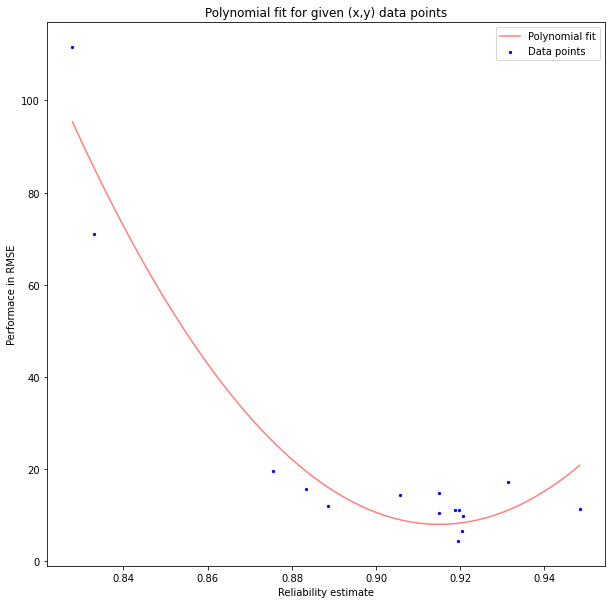

In [78]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['RMSE'].values, 2, xlabel='Reliability estimate', ylabel='Performace in RMSE')

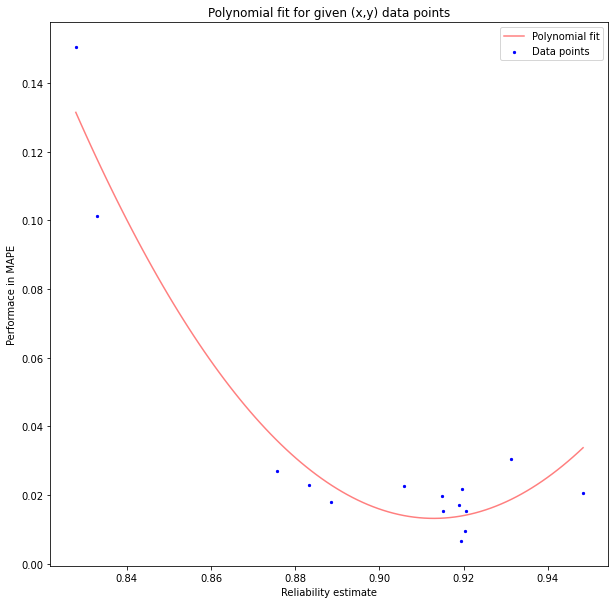

In [79]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['MAPE'].values, 2, xlabel='Reliability estimate', ylabel='Performace in MAPE')

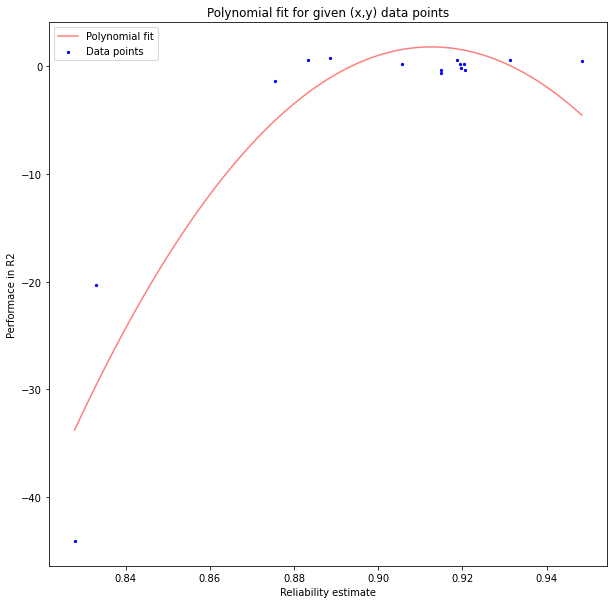

In [80]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['R2-score'].values, 2, xlabel='Reliability estimate', ylabel='Performace in R2')

In [81]:
scaler = MinMaxScaler()

In [82]:
x = np.array(df_RE['staDRE'].values)
y = np.array(df_RE['RMSE'].values)
# ya = np.array(airtel['MAPE'].values)
# ya = np.array(airtel['R2-score'].values)

z = np.polyfit(x, y, 2)

fit = np.poly1d(z)

x_min = x.min()
x_max = x.max()

xp = np.linspace(x_min, x_max, 100)
yp = fit(xp)

In [83]:
fit

poly1d([ 11502.95911097, -21050.46579592,   9638.6582468 ])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


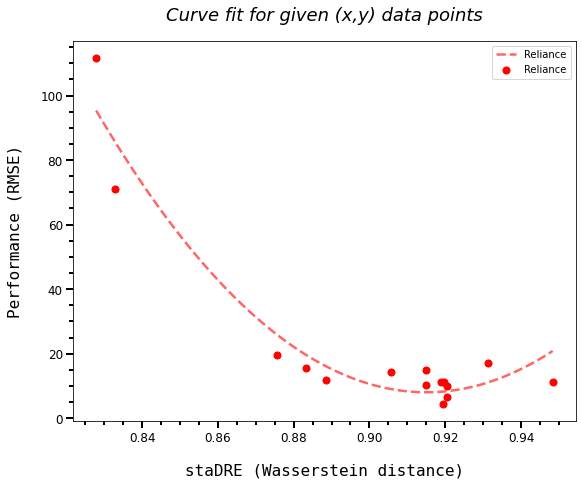

In [84]:
#Plotting RMSE-staDRE
fig1 = plt.figure(figsize=(9,7))
ax1 = fig1.subplots()
ax1.plot(xp, yp, 'r', linestyle='dashed', linewidth=2.5, alpha = 0.6, label = 'Reliance')
ax1.scatter(x, y, 50, 'r', "o", label = 'Reliance')
ax1.set_xlabel('staDRE (Wasserstein distance)', fontsize=16, family='monospace')
plt.xticks(fontsize=12)
ax1.tick_params(which='both', width=2, length=7)
ax1.tick_params(which='minor', length=4)
ax1.xaxis.labelpad = 18
ax1.set_ylabel('Performance (RMSE)', fontsize=16, family='monospace')
plt.yticks(fontsize=12)
ax1.yaxis.labelpad = 18
ax1.set_title('Curve fit for given (x,y) data points', fontsize=18, style='italic', pad=20)
plt.minorticks_on()
ax1.legend(loc='best')

plt.savefig('RMSE_vs._staDRE.eps', dpi=500)
plt.savefig('RMSE_vs._staDRE.jpg', dpi=500)
plt.savefig('RMSE_vs._staDRE.svg', dpi=500)
plt.show()

